In [161]:
#!/usr/bin/env python
# -*- coding: utf-8 -*-


# Deep Neural Networks

## Session 08b
## Introduction to Pytorch
- one hidden layer 
- ${tanh}$ activation function
- multi-class output
- FIFA dataset 

<img src='../../prasami_images/prasami_color_tutorials_small.png' width='400' alt="By Pramod Sharma : pramod.sharma@prasami.com" align="left"/>

In [162]:
import os
#import numpy as np
import pandas as pd

from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, classification_report
from sklearn.preprocessing import StandardScaler

import matplotlib.pyplot as plt

import torch
import torch.nn as nn

from utils.helper import fn_plot_torch_hist, fn_plot_confusion_matrix

In [163]:
# Some basic parameters
inpDir = '../../input'
outDir = '../output'

RANDOM_STATE = 24
torch.manual_seed(RANDOM_STATE) # Set Random Seed for reproducible  results

EPOCHS = 2001 # number of epochs
ALPHA = 0.001 # learning rate
TEST_SIZE = 0.2

# parameters for Matplotlib
params = {'legend.fontsize': 'medium',
          'figure.figsize': (15, 10),
          'axes.labelsize': 'medium',
          'axes.titlesize':'large',
          'xtick.labelsize':'medium',
          'ytick.labelsize':'medium'
         }

CMAP = plt.cm.Spectral

plt.rcParams.update(params)

## Helper Function
* Import from util.helper

## Read FIFA 2019 data set
<img src = '../../images/fifa_2019.png' alt = 'Fifa 2019'>

In [164]:
data_df = pd.read_csv(os.path.join(inpDir, 'fifa_2019.csv'))
data_df.shape

(18207, 89)

In [165]:
# removing rows with position = null
data_df = data_df[data_df["Position"].notnull()]
data_df.head()

,Unnamed: 0,ID,Name,Age,Photo,Nationality,Flag,Overall,Potential,Club,...,Composure,Marking,StandingTackle,SlidingTackle,GKDiving,GKHandling,GKKicking,GKPositioning,GKReflexes,Release Clause
0,0,158023,L. Messi,31,https://cdn.sofifa.org/players/4/19/158023.png,Argentina,https://cdn.sofifa.org/flags/52.png,94,94,FC Barcelona,...,96.0,33.0,28.0,26.0,6.0,11.0,15.0,14.0,8.0,€226.5M
1,1,20801,Cristiano Ronaldo,33,https://cdn.sofifa.org/players/4/19/20801.png,Portugal,https://cdn.sofifa.org/flags/38.png,94,94,Juventus,...,95.0,28.0,31.0,23.0,7.0,11.0,15.0,14.0,11.0,€127.1M
2,2,190871,Neymar Jr,26,https://cdn.sofifa.org/players/4/19/190871.png,Brazil,https://cdn.sofifa.org/flags/54.png,92,93,Paris Saint-Germain,...,94.0,27.0,24.0,33.0,9.0,9.0,15.0,15.0,11.0,€228.1M
3,3,193080,De Gea,27,https://cdn.sofifa.org/players/4/19/193080.png,Spain,https://cdn.sofifa.org/flags/45.png,91,93,Manchester United,...,68.0,15.0,21.0,13.0,90.0,85.0,87.0,88.0,94.0,€138.6M
4,4,192985,K. De Bruyne,27,https://cdn.sofifa.org/players/4/19/192985.png,Belgium,https://cdn.sofifa.org/flags/7.png,91,92,Manchester City,...,88.0,68.0,58.0,51.0,15.0,13.0,5.0,10.0,13.0,€196.4M


In [166]:
# Following columns appear to be relevant for our analysis
rel_cols = ["Position", 'Finishing', 'HeadingAccuracy', 'ShortPassing', 'Volleys', 'Dribbling',
            'Curve', 'FKAccuracy', 'LongPassing', 'BallControl', 'Acceleration',
            'SprintSpeed', 'Agility', 'Reactions', 'Balance', 'ShotPower',
            'Jumping', 'Stamina', 'Strength', 'LongShots', 'Aggression',
            'Interceptions', 'Positioning', 'Vision', 'Penalties', 'Composure',
            'Marking', 'StandingTackle', 'SlidingTackle', 'GKDiving', 'GKHandling',
            'GKKicking', 'GKPositioning', 'GKReflexes']

In [167]:
goalkeeper = 'GK'
forward = ['ST', 'LW', 'RW', 'LF', 'RF', 'RS','LS', 'CF']
midfielder = ['CM','RCM','LCM', 'CDM','RDM','LDM', 'CAM', 'LAM', 'RAM', 'RM', 'LM']
defender = ['CB', 'RCB', 'LCB', 'LWB', 'RWB', 'LB', 'RB']

In [168]:
#Assign labels to goalkeepers
data_df.loc[data_df["Position"] == "GK", "Position"] = 0

#Defenders
data_df.loc[data_df["Position"].isin(defender), "Position"] = 1

#Midfielders
data_df.loc[data_df["Position"].isin(midfielder), "Position"] = 2

#Forward
data_df.loc[data_df["Position"].isin(forward), "Position"] = 3

# Convert Column "Position" to numeric so that Pandas does not complain
data_df['Position'] = pd.to_numeric(data_df['Position'], downcast="integer")

In [169]:
data_df = data_df[rel_cols]
data_df.head()

,Position,Finishing,HeadingAccuracy,ShortPassing,Volleys,Dribbling,Curve,FKAccuracy,LongPassing,BallControl,...,Penalties,Composure,Marking,StandingTackle,SlidingTackle,GKDiving,GKHandling,GKKicking,GKPositioning,GKReflexes
0,3,95.0,70.0,90.0,86.0,97.0,93.0,94.0,87.0,96.0,...,75.0,96.0,33.0,28.0,26.0,6.0,11.0,15.0,14.0,8.0
1,3,94.0,89.0,81.0,87.0,88.0,81.0,76.0,77.0,94.0,...,85.0,95.0,28.0,31.0,23.0,7.0,11.0,15.0,14.0,11.0
2,3,87.0,62.0,84.0,84.0,96.0,88.0,87.0,78.0,95.0,...,81.0,94.0,27.0,24.0,33.0,9.0,9.0,15.0,15.0,11.0
3,0,13.0,21.0,50.0,13.0,18.0,21.0,19.0,51.0,42.0,...,40.0,68.0,15.0,21.0,13.0,90.0,85.0,87.0,88.0,94.0
4,2,82.0,55.0,92.0,82.0,86.0,85.0,83.0,91.0,91.0,...,79.0,88.0,68.0,58.0,51.0,15.0,13.0,5.0,10.0,13.0


In [170]:
class_labels = {0: 'GK', 1: 'Defender', 2: 'Mid Fielder', 3 : 'Forward'}

In [171]:
y = data_df["Position"].to_numpy()

X = data_df.drop("Position", axis = 1)

X.shape, y.shape

((18147, 33), (18147,))

In [172]:
#  Split the data in training and test sets to measure performance of the model.
X_train, X_test, y_train, y_test = train_test_split(X, y, 
                                                    test_size=TEST_SIZE, 
                                                    stratify=y, 
                                                    random_state=RANDOM_STATE )

print (X_train.shape, y_train.shape, X_test.shape, y_test.shape)

(14517, 33) (14517,) (3630, 33) (3630,)


In [173]:
sc = StandardScaler()

X_train = sc.fit_transform(X_train)

X_test = sc.transform(X_test)

In [174]:
torch.cuda.is_available()

True

In [175]:
torch.version.cuda

'12.1'

In [176]:
torch.cuda.get_device_name(torch.cuda.current_device())

'NVIDIA GeForce RTX 3060 Laptop GPU'

In [177]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
device

'cuda'

In [178]:
input_dim = X_train.shape[1]

model = nn.Sequential(
    nn.Linear( input_dim, 18),
    nn.Tanh(),
    nn.Linear( 18, 4),).to(device=device)

In [179]:
print(model)

Sequential(
  (0): Linear(in_features=33, out_features=18, bias=True)
  (1): Tanh()
  (2): Linear(in_features=18, out_features=4, bias=True)
)


### Alternate model creation
>class Model ( nn.Module ):
    
>    def __init__ (self, input_dim):
        
>        super( Model, self).__init__()
        
>        self.layer1 = nn.Linear( input_dim, 18)
        
>        self.layer2 = nn.Linear( 18, 4)
        
>    def forward(self, x):
        
>        x = F.silu (  self.layer1 ( x ) ) # Layer 1 activations

>        x =   self.layer2 ( x ) # Layer 2 activations
    
>        return x

In [180]:
list(model.parameters())

[Parameter containing:
 tensor([[ 9.2062e-02, -4.3501e-02, -1.4794e-01,  1.0717e-02,  1.6225e-01,
          -7.7643e-02, -5.6670e-02,  1.3613e-01, -2.4222e-02, -6.6486e-02,
          -3.5062e-02,  6.3746e-03, -1.4182e-01, -4.9749e-02,  1.6879e-01,
          -3.7317e-02,  1.5855e-01, -6.7960e-02, -7.0020e-02, -5.1887e-02,
          -1.5565e-01, -1.0485e-01,  1.0520e-01, -1.3059e-01,  5.9465e-02,
           1.6379e-01, -2.2121e-02,  7.6153e-02,  8.1313e-02, -1.2426e-01,
          -6.7123e-02, -5.4516e-02,  1.6798e-01],
         [-1.5537e-01,  1.0537e-01,  1.6350e-01,  1.3764e-01,  7.4190e-02,
           7.7494e-02, -9.2818e-03,  8.7583e-02,  1.5868e-01, -5.5976e-02,
           1.6820e-01,  2.7665e-02, -1.2210e-01, -1.2494e-01,  6.1399e-02,
          -2.4561e-02, -7.6685e-02,  8.8150e-02, -9.1821e-02, -8.3203e-02,
           3.2539e-02, -3.1431e-02, -1.4688e-01, -5.2295e-02, -6.1178e-02,
          -7.4187e-02,  1.3552e-01, -2.6404e-02, -1.0632e-01,  5.1576e-02,
           2.9993e-02, -1.3

In [181]:
print (f'Num Parameters: {len(list(model.parameters()))}')  
print (f'Layer 1: Weights : {list(model.parameters())[0].shape}')
print (f'Layer 1: Bias    : {list(model.parameters())[1].shape}')
print (f'Layer 2: Weights : {list(model.parameters())[2].shape}')
print (f'Layer 2: Bias    : {list(model.parameters())[3].shape}')

Num Parameters: 4
Layer 1: Weights : torch.Size([18, 33])
Layer 1: Bias    : torch.Size([18])
Layer 2: Weights : torch.Size([4, 18])
Layer 2: Bias    : torch.Size([4])


In [182]:
train_X = torch.tensor(X_train, dtype=torch.float32, device=device)
train_y = torch.tensor(y_train, dtype=torch.int64, device=device)

test_X = torch.tensor(X_test, dtype=torch.float32, device=device)
test_y = torch.tensor(y_test, dtype=torch.int64, device=device)



In [183]:
train_X[:1].shape, train_X[0].shape

(torch.Size([1, 33]), torch.Size([33]))

### Use train_x[:1] to keep dimensions rather than train_X[0]

## Making predictions

In [184]:
predict_prob = model(train_X[:1]) # make predictions 
predict_prob.detach().cpu().numpy()

array([[-0.40813163, -0.18573728,  0.13504393, -0.1031108 ]],
      dtype=float32)

In [185]:
y_train[0]

3

Obviously its incorrect as we have not trained the model. Lets train the model.

In [186]:
# Loss Function
loss_fn = nn.CrossEntropyLoss()

# Optimizers
optimizer = torch.optim.Adam(model.parameters(), lr = ALPHA)

# Iterations
for epoch in range (EPOCHS):
    
    model.train() # Set the model in training mode
    
    predict_prob = model(train_X) # make predictions
    
    curr_loss = loss_fn(predict_prob, train_y) # calculate loss

    ###---------------
    ### Back prop step
    ###---------------
    optimizer.zero_grad() 
    curr_loss.backward()
    optimizer.step()

In [187]:
# Lets see prediction for first row
predict_prob = model(train_X[:1]) # make predictions 
predict_prob.detach().cpu().numpy()

array([[-2.0880373, -3.5062962,  1.9967432,  5.2325616]], dtype=float32)

In [188]:
predict_prob.argmax().item(), train_y[0].item()

(3, 3)

! Voila prediction matches with the ground truth.

Lets add some tracking too.

In [189]:

del model

model = nn.Sequential(
    nn.Linear( input_dim, 18),
    nn.Tanh(),
    nn.Linear( 18, 4)
).to(device=device)

In [190]:
# Loss Function
loss_fn = nn.CrossEntropyLoss()

# Optimizers
optimizer = torch.optim.Adam(model.parameters(), lr = ALPHA)

# Some lists to collect data
loss = []
tloss = []
n_epoch = []
acc = []
tacc = []

# Iterations
for epoch in range (EPOCHS):
    
    model.train() # Set the model in training mode
    
    predict_prob = model(train_X) # make predictions
    
    curr_loss = loss_fn(predict_prob, train_y) # calculate loss

    ###---------------
    ### Back prop step
    ###---------------
    optimizer.zero_grad() 
    curr_loss.backward()
    optimizer.step()
    
    loss.append ( curr_loss.data.item() ) # append to loss list
    
    _, y_pred = torch.max(predict_prob, 1) # get predicted class from the probabilities
        
    curr_acc = accuracy_score( y_train, y_pred.data.cpu()) # move to CPU 
    
    acc.append(curr_acc) # append to accuracy list
    
    model.eval() # evaluation mode, prevent from learning
    
    predict_prob_tst = model(test_X) # make predictions on test data
    
    tcurr_loss = loss_fn( predict_prob_tst, test_y)
    
    tloss.append( tcurr_loss.data.item())  # append to loss list
    
    _, y_pred = torch.max(predict_prob_tst, 1) # get predicted class from the probabilities
    
    tcurr_acc = accuracy_score( y_test, y_pred.data.cpu()) # move to CPU 
    
    tacc.append(tcurr_acc) # append to accuracy list
    
    n_epoch.append(epoch)
    
        
    if epoch % 1000 == 0:
        fmtStr = 'Epoch :{:5d}/{:5d} --- Loss: {:.5f}/{:.5f} | Acc {:.5f}/{:.5f}'
        
        print (fmtStr.format(epoch, EPOCHS,
                             curr_loss.data.item(),
                             tcurr_loss.data.item(),  
                             curr_acc, 
                             tcurr_acc))

Epoch :    0/ 2001 --- Loss: 1.35766/1.34192 | Acc 0.39368/0.40606
Epoch : 1000/ 2001 --- Loss: 0.29407/0.30232 | Acc 0.87883/0.86777
Epoch : 2000/ 2001 --- Loss: 0.27246/0.29324 | Acc 0.88868/0.87796


In [191]:
loss_df = pd.DataFrame({'epoch': n_epoch,
                       'loss' : loss,
                       'test_loss' : tloss,
                       'acc' : acc,
                       'test_acc': tacc})

In [192]:
loss_df.head()

,epoch,loss,test_loss,acc,test_acc
0,0,1.357661,1.341921,0.393676,0.406061
1,1,1.339827,1.324475,0.403251,0.414050
2,2,1.322430,1.307461,0.409864,0.422039
3,3,1.305466,1.290874,0.415031,0.429201
4,4,1.288927,1.274711,0.420473,0.435813


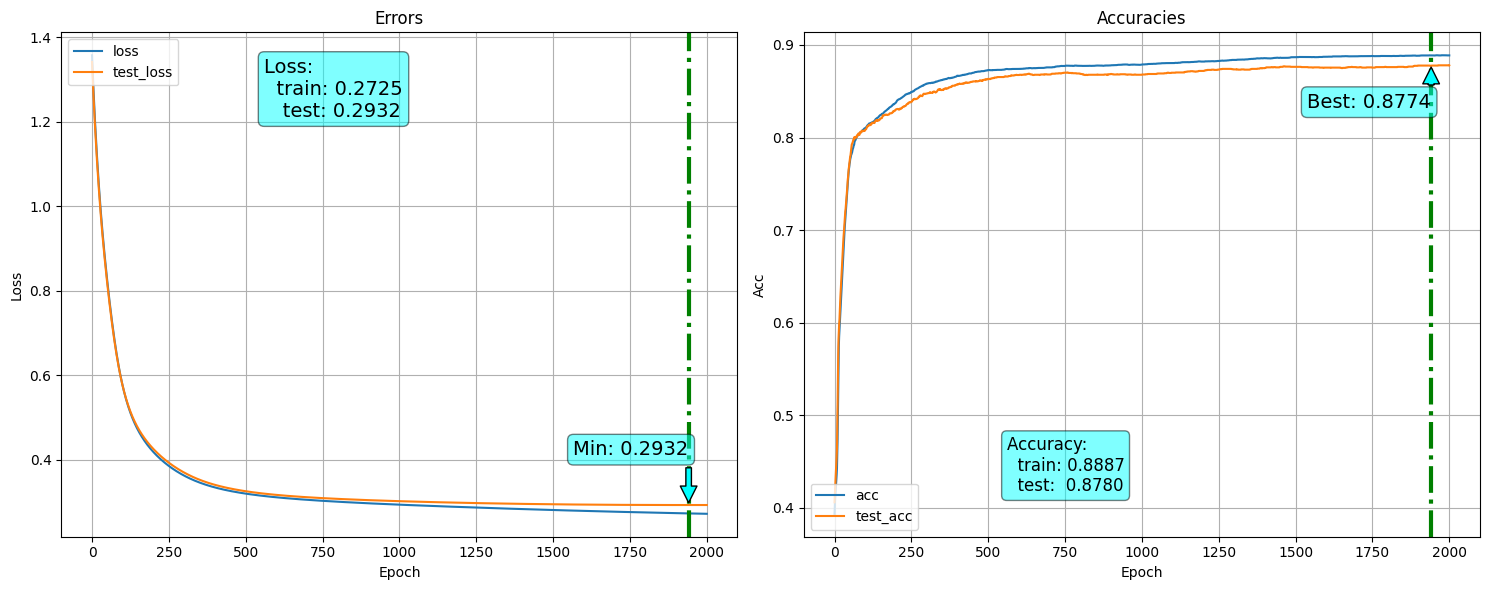

In [193]:
fn_plot_torch_hist(loss_df)

## Performance on Train Data

In [194]:
outputs = model(train_X)

y_pred = torch.argmax(outputs, dim = 1).cpu().numpy()

y_pred

array([3, 2, 2, ..., 0, 0, 0])

In [195]:
print(classification_report(train_y.cpu().numpy(), y_pred ))

              precision    recall  f1-score   support

           0       1.00      1.00      1.00      1620
           1       0.92      0.93      0.92      4693
           2       0.84      0.87      0.86      5470
           3       0.86      0.79      0.83      2734

    accuracy                           0.89     14517
   macro avg       0.91      0.90      0.90     14517
weighted avg       0.89      0.89      0.89     14517



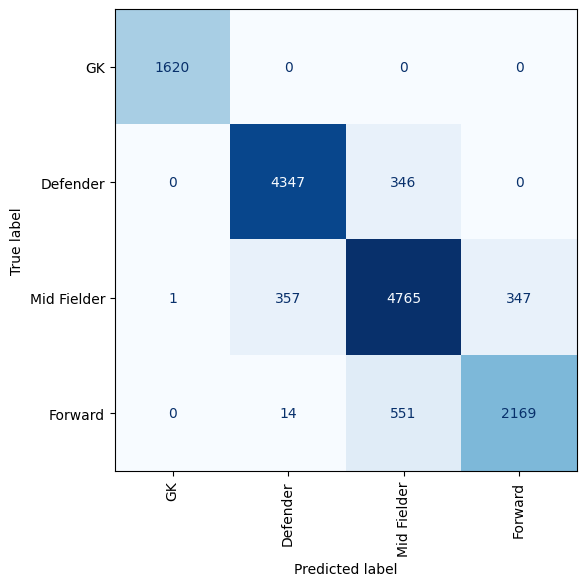

In [196]:
fn_plot_confusion_matrix(train_y.cpu().numpy(), y_pred, labels=class_labels)

## Performance on test data

In [197]:
outputs = model(test_X)

y_pred = outputs.argmax(dim=1).cpu().numpy()

print(classification_report(test_y.cpu().numpy(), y_pred ))

              precision    recall  f1-score   support

           0       1.00      1.00      1.00       405
           1       0.92      0.92      0.92      1173
           2       0.82      0.87      0.85      1368
           3       0.84      0.74      0.79       684

    accuracy                           0.88      3630
   macro avg       0.90      0.88      0.89      3630
weighted avg       0.88      0.88      0.88      3630



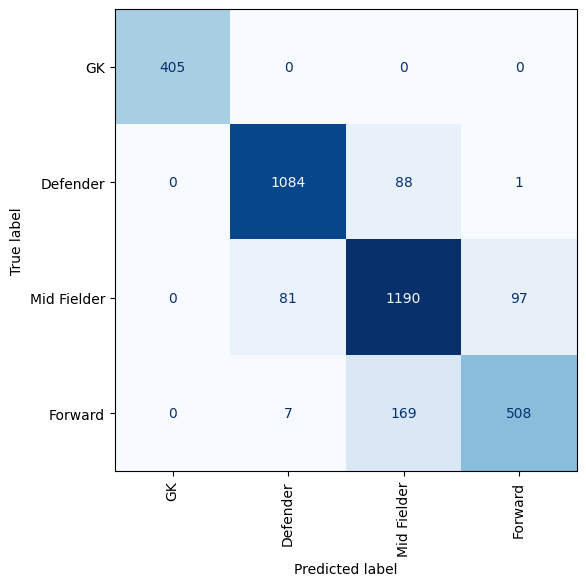

In [198]:
fn_plot_confusion_matrix(test_y.cpu().numpy(), y_pred, labels=class_labels)